# Домашнее задание 5

Ссылка на семинар: https://colab.research.google.com/drive/1_G8kdmhtokmAUeMsSrl1IKqIs3_FEbeK?usp=sharing

Не забудьте поставить видеокарту в качестве аппаратного ускорителя :)

### Сохранение и загрузка

[3 балла] 

Сделайте сохранение моделей после обучения (в формате .pth). В случае маленьких сетей на маленьких данных в этом нет необходимости, но в других случаях можно сохранять версию модели (checkpoint) каждые несколько (к примеру 5) эпох. Сделайте и протестируйте загрузку моделей для задачи классификации рукописных цифр.

### Сверточная сеть на CIFAR-10

[5 баллов]

Решите задачу классификации на другом датасете - CIFAR-10 https://en.wikipedia.org/wiki/CIFAR-10
В примерах к Pytorch есть полное решение этой задачи, но попробуйте придумать его самостоятельно. Этот датасет отличается от mnist тем, что изображения в нём имеют размер не 28x28, а 32x32x3, то есть они трёхканальные, "цветные". Для того, чтобы сеть заработала и начала хотя бы как-то учиться, нужно сделать так, чтобы размеры (shapes) тензоров на выходе предыдущего слоя совпадали с размером тензоров на входе следующего слоя.

### Классификация на своих картинках

[6 баллов]

Запустите распознавание цифр на самостоятельно записанных данных. Можно использовать фотографию листочка, можно просто нарисовать их в пейнте. Чтобы все заработало, нужнро во-первых помнить, что сеть, созданная для работы с mnist, принимает на вход одноканальные картинки 28x28, а во-вторых учесть, что границы цифр в обучающих данных не резкие, в процессе их подготовки был применён антиалеасинг.

### Загадка

Доп.задача 1 [5 баллов]

Найдите, почему при обучении свёрточной сети (Conv_net в семинаре) test loss всё время меньше train loss-а. Напишите, почему так получается, исправьте ошибку, если она есть. Обратите внимание, что при обучении Simple_net такого не наблюдается.

In [1]:
import torch
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
batch_size = 64
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

tensor(0)


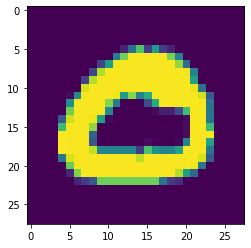

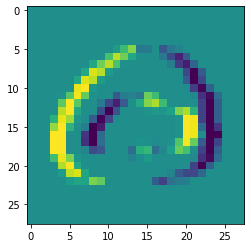

In [3]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import cv2

for data, target in train_loader:
    for i in range (1):
        print (target [i])
        img = data [i, 0, :, :]
        plt.imshow (img)
        plt.show ()

        #kernel = np.ones((3, 3),np.float32)
        kernel = np.array([[-1, 0, 1]],np.float32)

        #print (type (img))
        convolved = cv2.filter2D(img.detach().cpu().numpy(),-1,kernel)
        plt.imshow (convolved)
        plt.show ()

    break

In [4]:
class Simple_net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Simple_net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #torch.Size([64, 1, 28, 28])
        x = self.conv1(x)
        #torch.Size([64, 32, 26, 26])
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        #torch.Size([64, 64, 12, 12])
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #torch.Size([64, 9216])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        output = F.log_softmax(x, dim=1)
        #torch.Size([64, 10])
        return output

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive, train=True):
    train_loss = 0

    if (train):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    
    else:
        model.eval()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
         
            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293850
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.492650
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.562617
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.487748
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.302307
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.314819
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.383444
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.156694
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.165475
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.423497
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.309146
Train Epoch: 1 [6400/10000 (64%)]	Loss: 0.168932


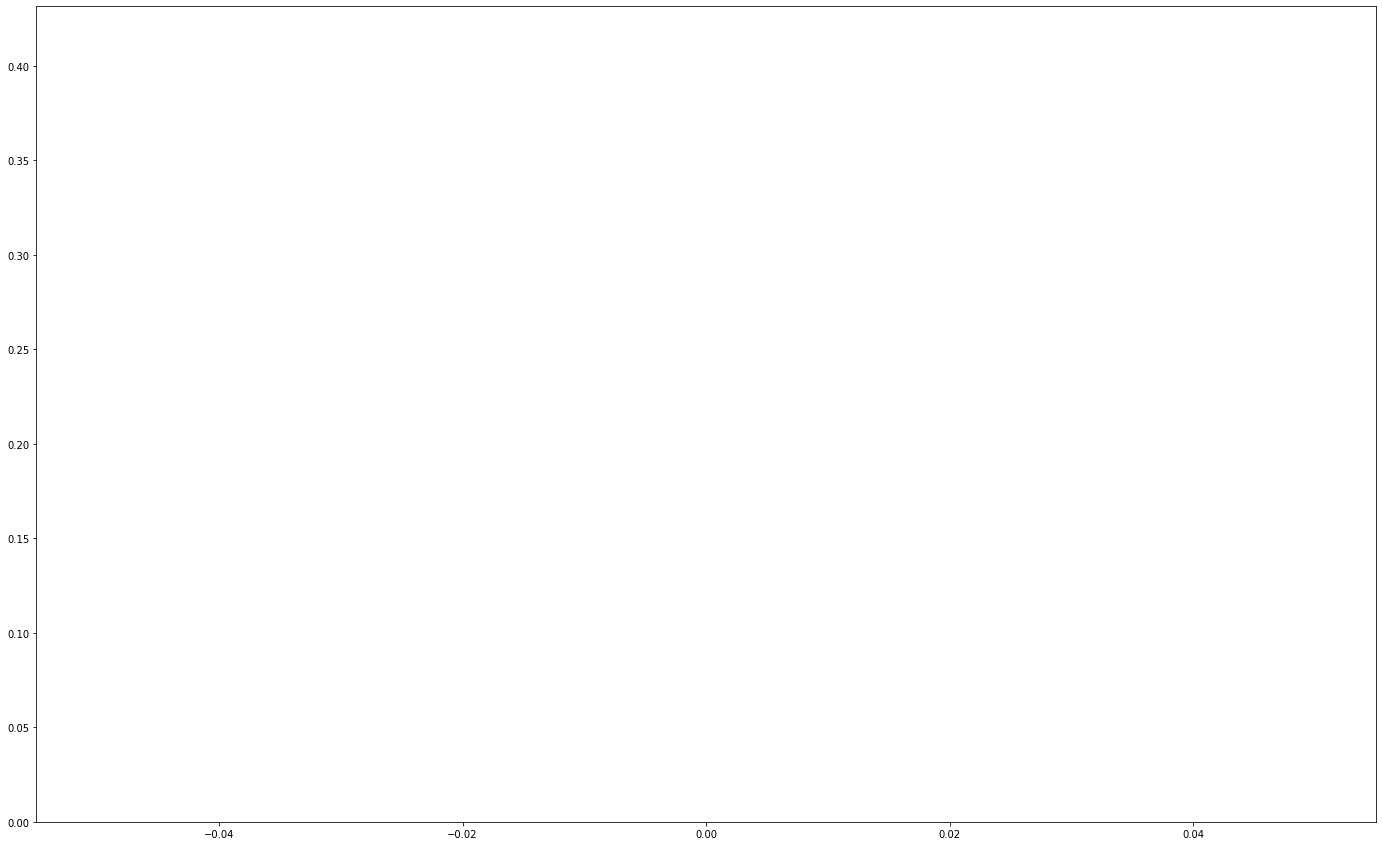

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.169654
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.091238
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.155144
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.255166
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.163612
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.254709
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.201246
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.238253
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.112037
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.066509
Train Epoch: 2 [0/10000 (0%)]	Loss: 0.134253
Train Epoch: 2 [6400/10000 (64%)]	Loss: 0.121421


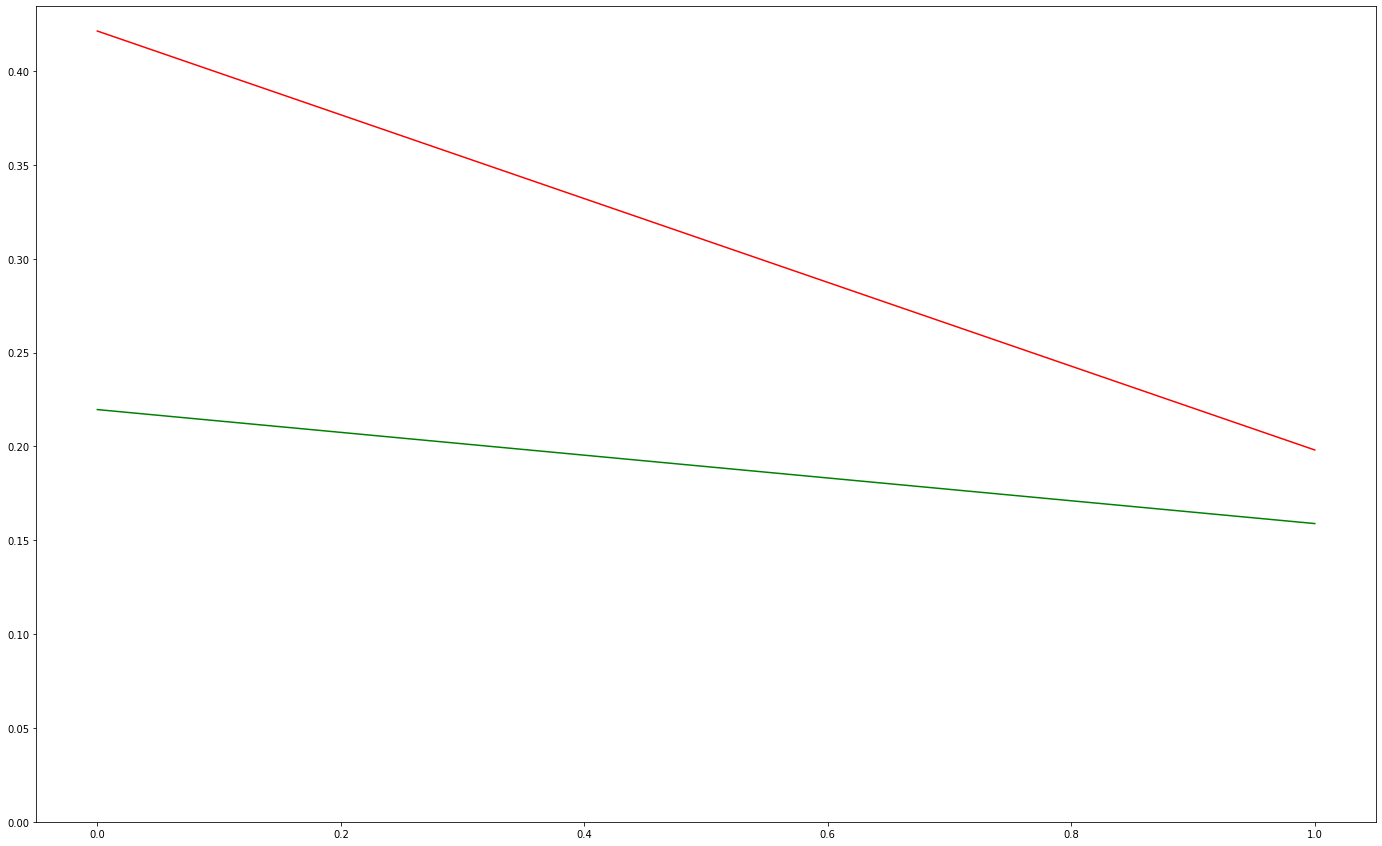

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.168558
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.073568
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.133554
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.182481
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.101528
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.209089
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.201084
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.109288
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.123529
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.114913
Train Epoch: 3 [0/10000 (0%)]	Loss: 0.081682
Train Epoch: 3 [6400/10000 (64%)]	Loss: 0.114118


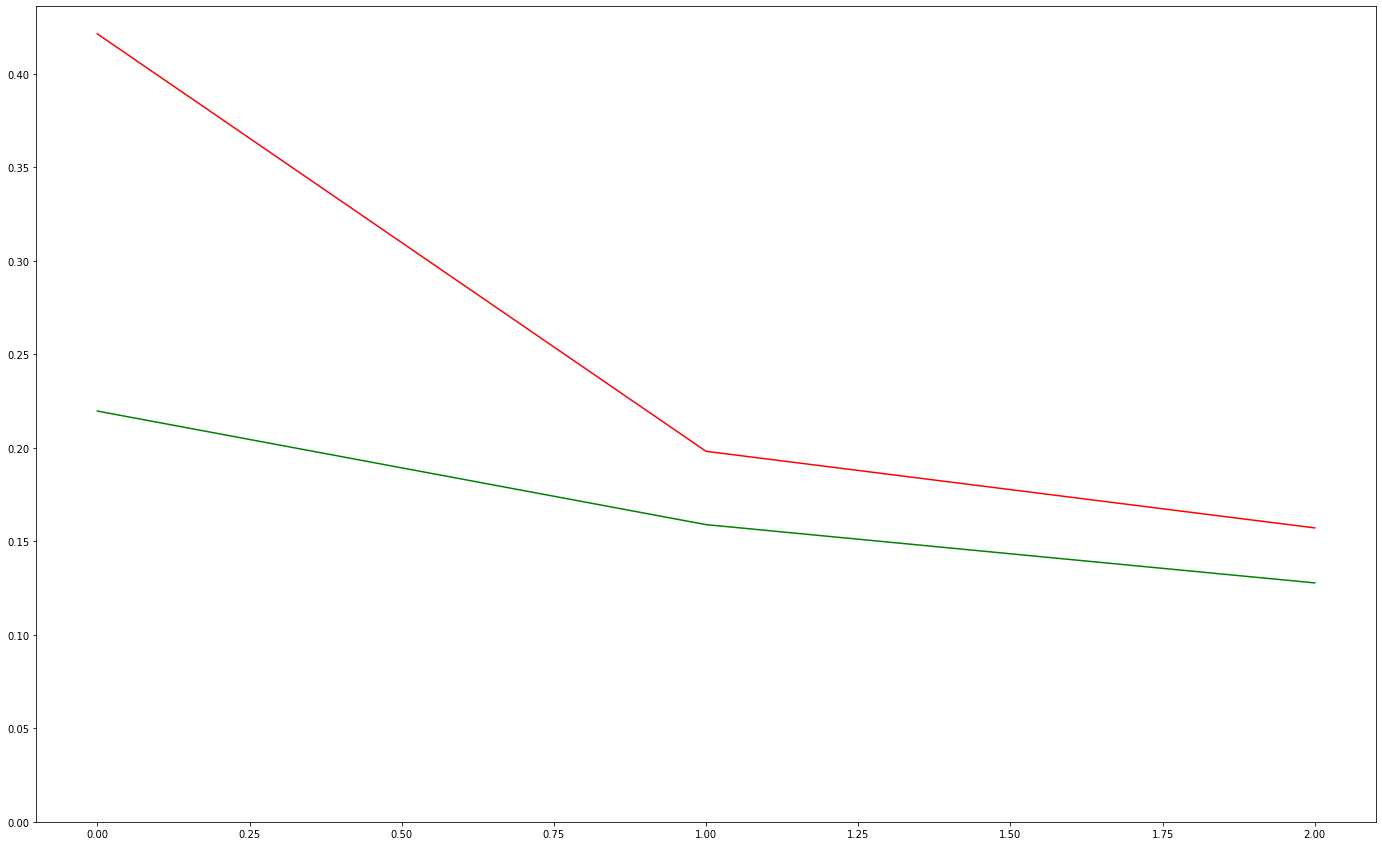

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.088758
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.072753
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.160966
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.137493
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.047925
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.108491
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.146658
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.229395
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.085687
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.048563
Train Epoch: 4 [0/10000 (0%)]	Loss: 0.125934
Train Epoch: 4 [6400/10000 (64%)]	Loss: 0.108198


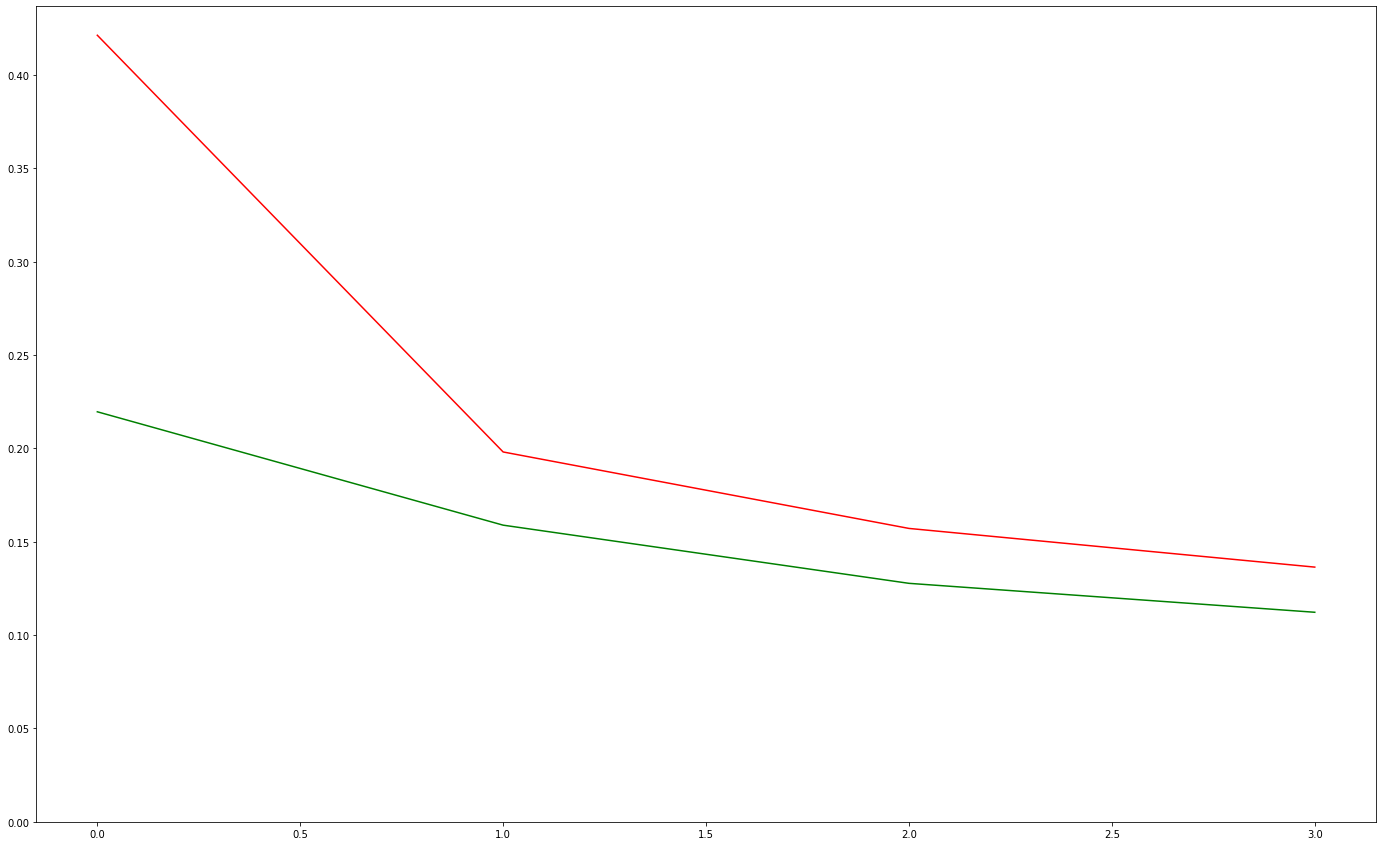

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.263039
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.083272
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.091495
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.110138
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.142902
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.094165
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.211939
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.140125
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.094632
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.046525
Train Epoch: 5 [0/10000 (0%)]	Loss: 0.120182
Train Epoch: 5 [6400/10000 (64%)]	Loss: 0.044651


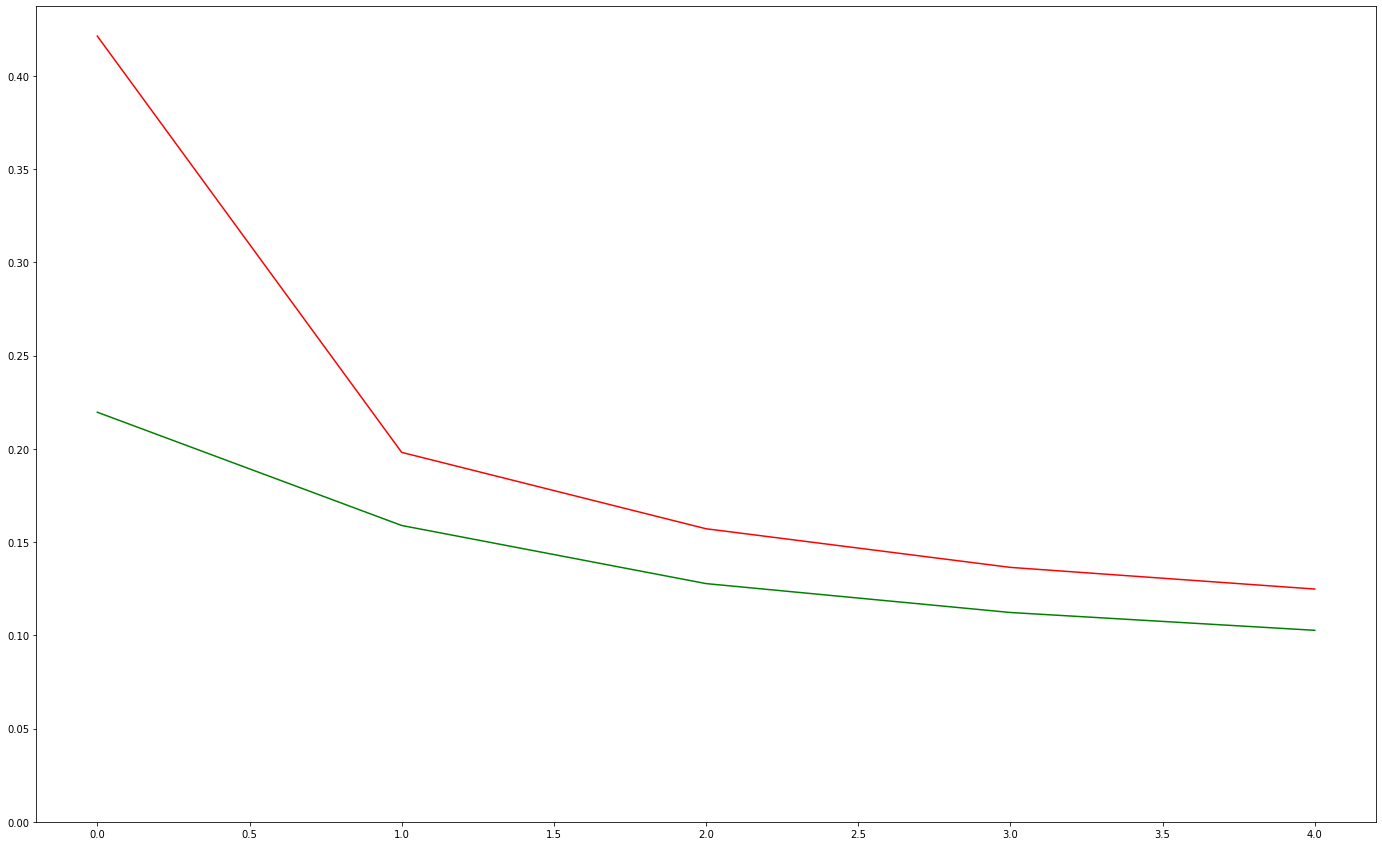

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.140267
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.139481
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.106526
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.187816
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.056196
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.100452
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.109645
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.058183
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.121294
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.044684
Train Epoch: 6 [0/10000 (0%)]	Loss: 0.183442
Train Epoch: 6 [6400/10000 (64%)]	Loss: 0.118157


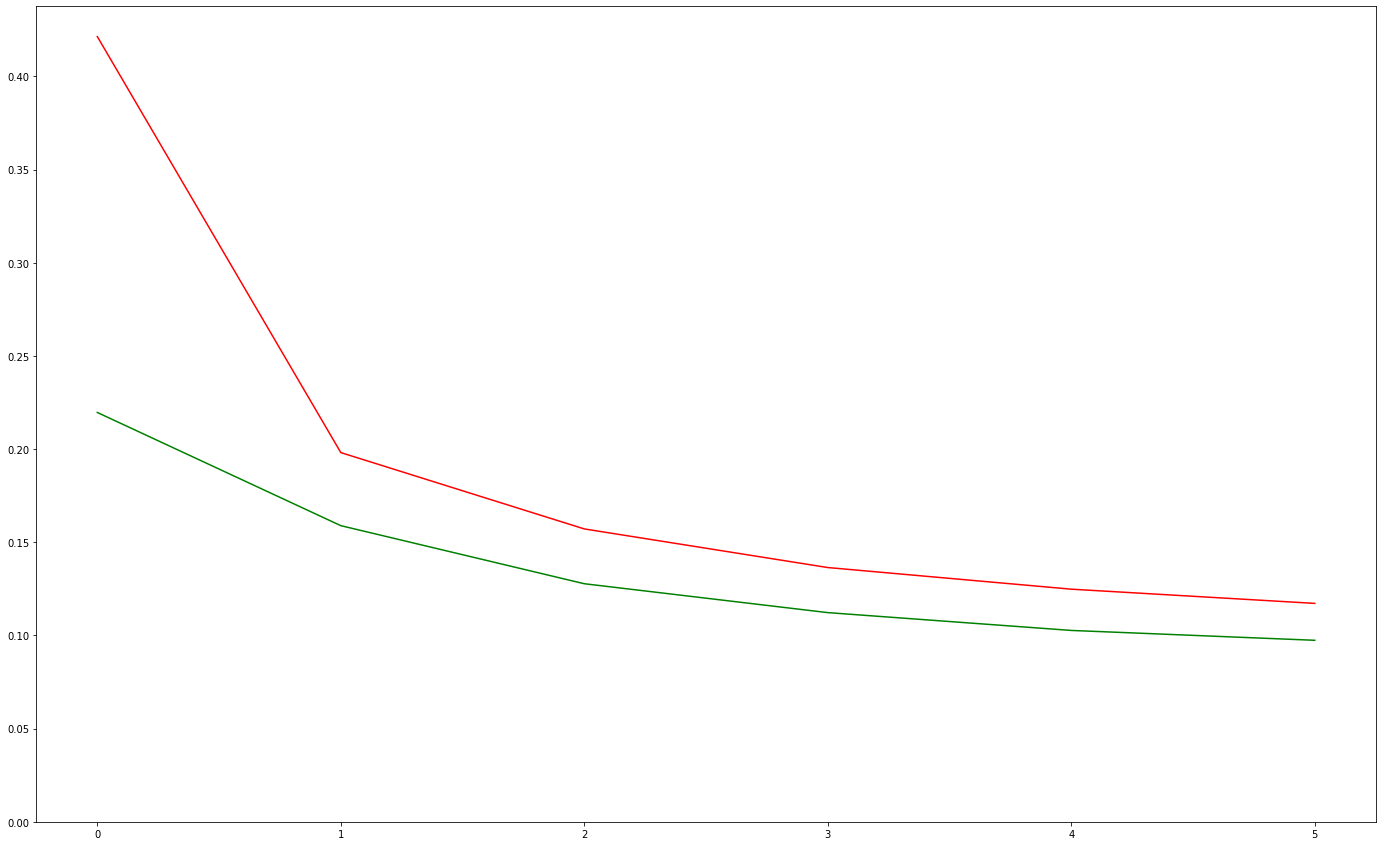

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.050798
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.103380
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.030300
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.098944
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.142491
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.072164
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.089298
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.113954
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.215776
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.039398
Train Epoch: 7 [0/10000 (0%)]	Loss: 0.119026
Train Epoch: 7 [6400/10000 (64%)]	Loss: 0.042309


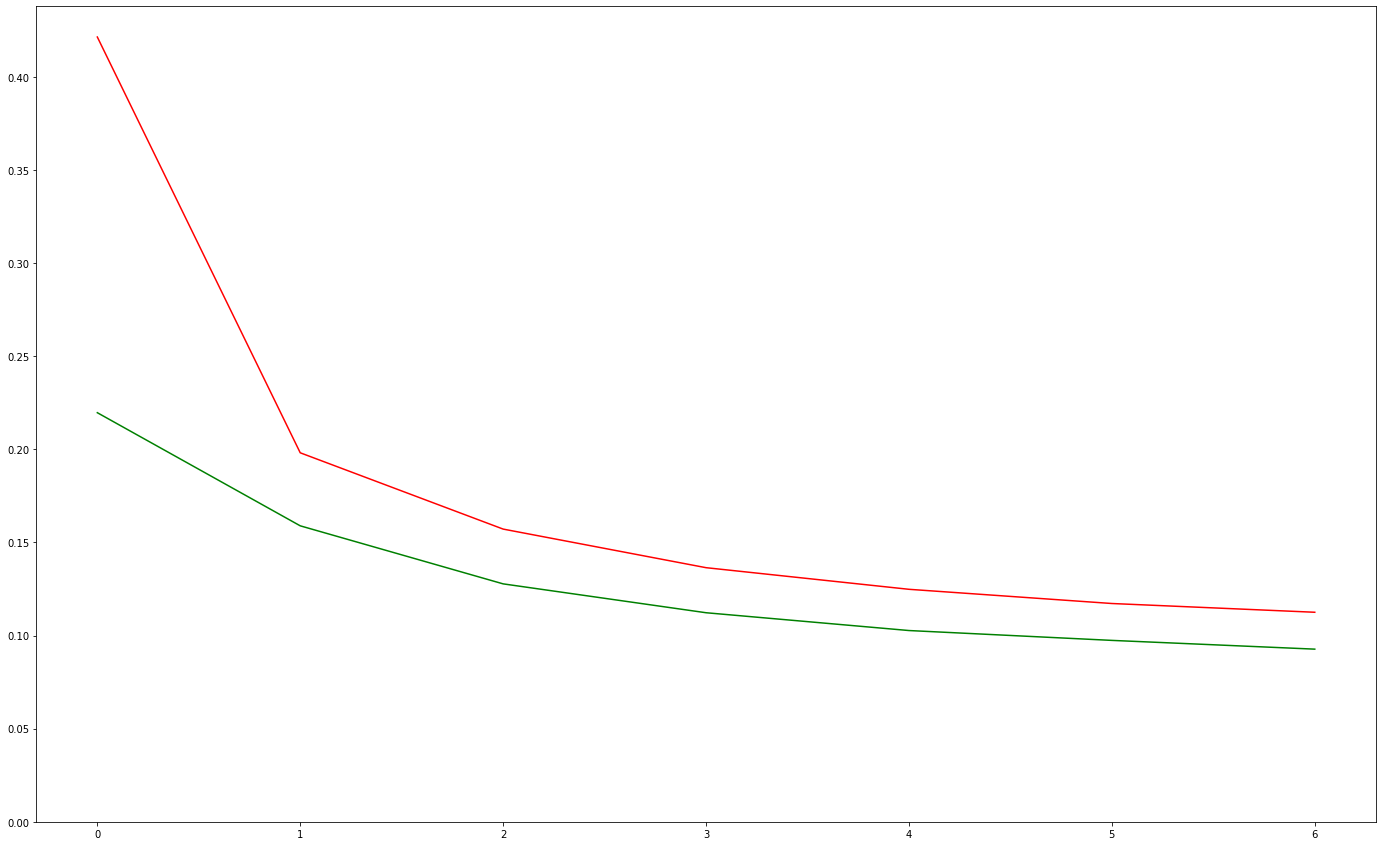

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.076335
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.082857
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.324955
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.093558
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.087534
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.088752
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.045366
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.231948
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.225537
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.208978
Train Epoch: 8 [0/10000 (0%)]	Loss: 0.196185
Train Epoch: 8 [6400/10000 (64%)]	Loss: 0.088109


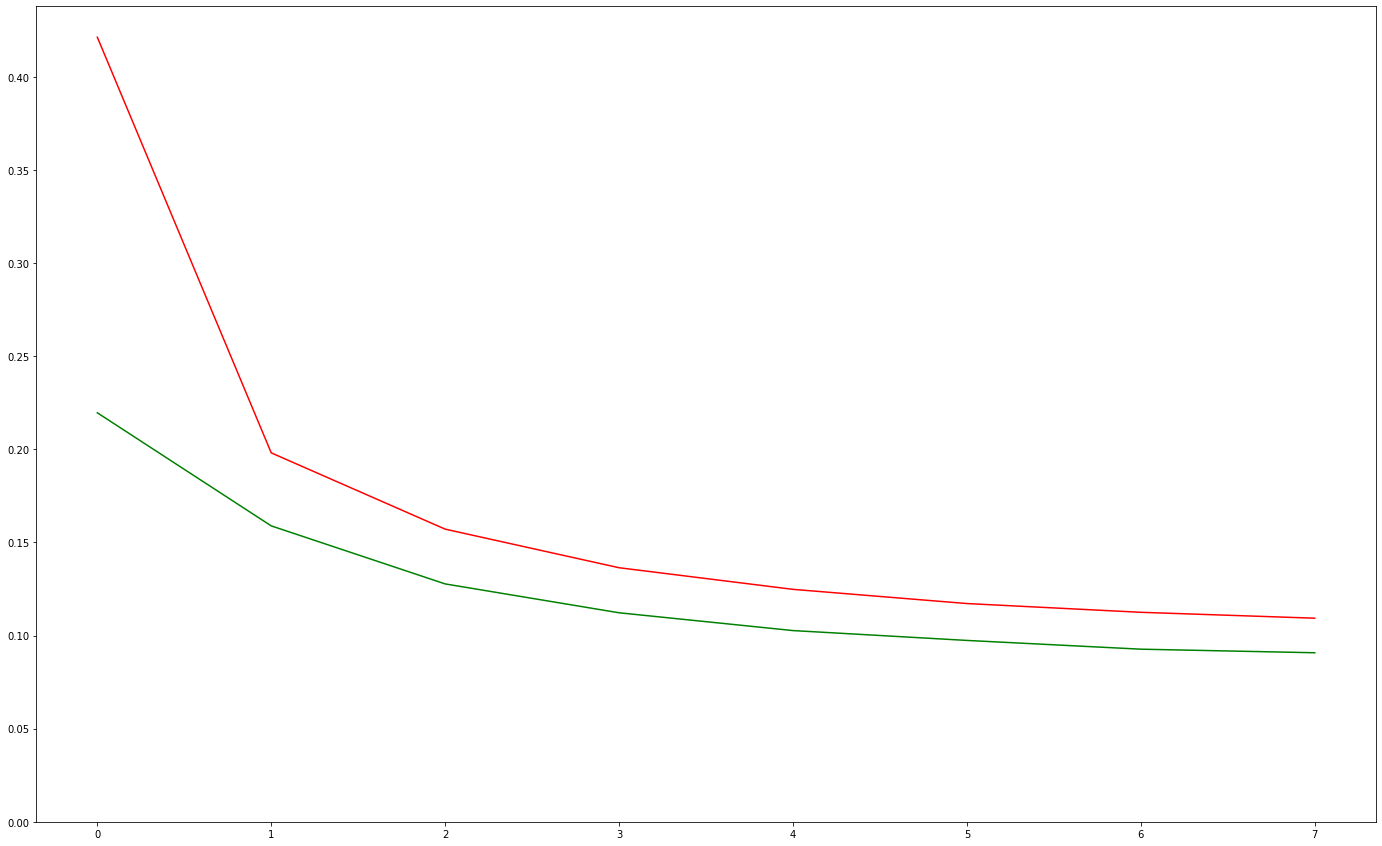

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.161084
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.054089
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.139106
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.180953
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.209714
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.067653
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.268416
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.018410
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.250976
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.199316
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.093492
Train Epoch: 9 [6400/10000 (64%)]	Loss: 0.022977


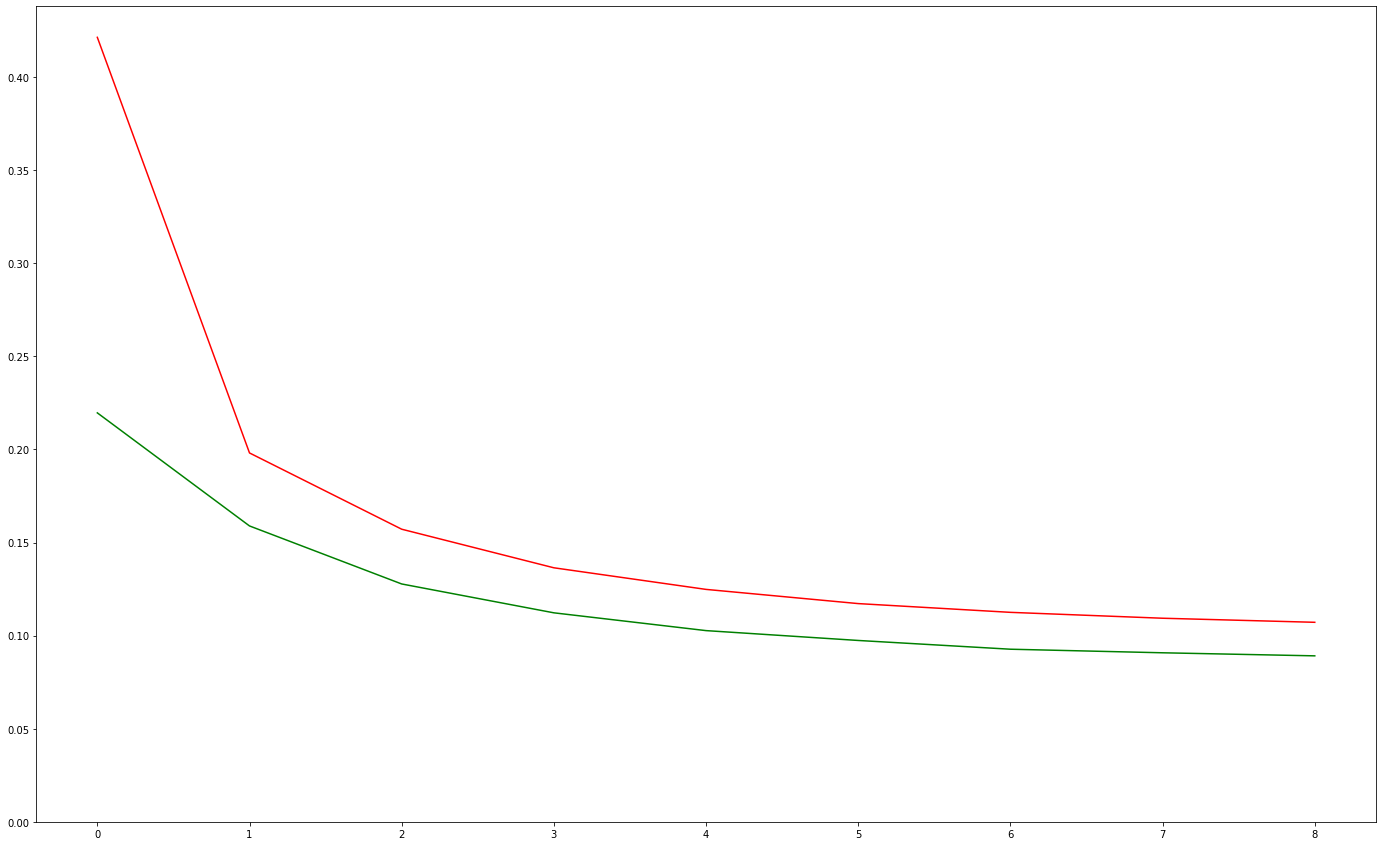

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.129890
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.107014
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.260121
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.072589
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.082315
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.073691
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.057925
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.028614
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.026088
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.094497
Train Epoch: 10 [0/10000 (0%)]	Loss: 0.101648
Train Epoch: 10 [6400/10000 (64%)]	Loss: 0.102688


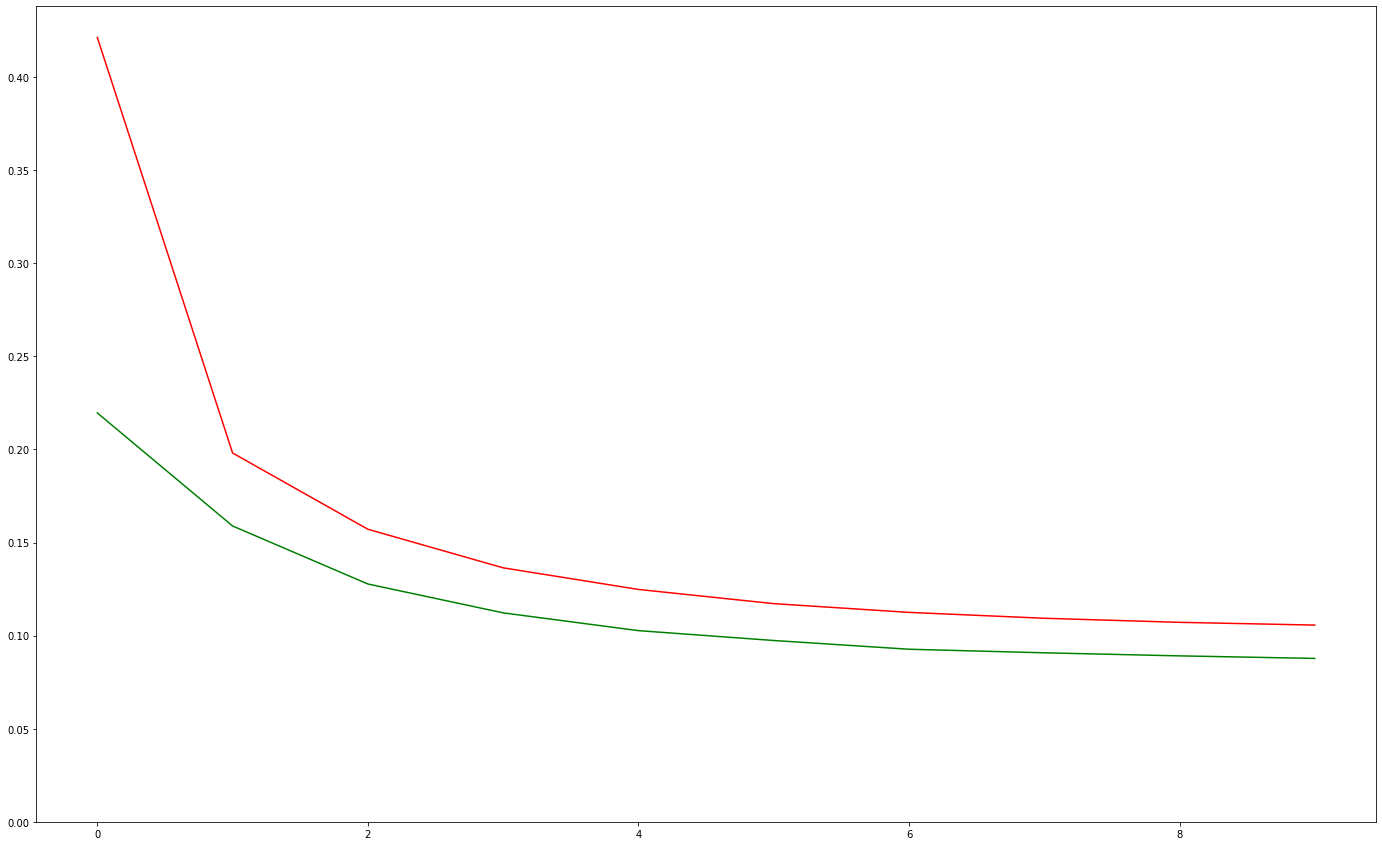

In [6]:
epochs          = 10
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

model = Simple_net(100, 10).to(device)
#model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    train(model, device, test_loader, optimizer, epoch, log_interval, test_loss)

    # test(model, device, test_loader, test_loss)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)

In [7]:
# сохранение не всей модели, а толко стейт дикт, там можно и всю сохранить
PATH ="cifri.pth"
torch.save(model.state_dict(), PATH)

In [8]:
# Загрузка весов из файла, опять же можно прям целую модель загрузить, 
# а можно вообoще подгружать из торчхаба
model.load_state_dict(torch.load(PATH))
model.eval()

Simple_net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [30]:
import matplotlib.pyplot as plt
def test(model, device, test_loader, loss_archive):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
#             print(output)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss = test_loss / len(test_loader)
    loss_archive.append (test_loss)
    print(pred)
#     img = data [i, 0, :, :]
#     plt.imshow (img)
#     plt.show (
    print(output)
    print(len(data.cpu()))
    for inm in data.cpu():
#  
        plt.imshow(inm[0])
        plt.show ()
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

tensor([[6],
        [1],
        [8],
        [5],
        [9],
        [7],
        [2],
        [3],
        [3],
        [5],
        [8],
        [4],
        [2],
        [7],
        [9],
        [7]], device='cuda:0')
tensor([[-1.2611e+01, -1.4727e+01, -9.7466e+00, -1.4673e+01, -1.0679e+01,
         -1.0977e+01, -1.1288e-04, -1.6447e+01, -1.1537e+01, -1.5162e+01],
        [-1.7188e+01, -1.7962e-03, -9.8714e+00, -7.5513e+00, -8.9584e+00,
         -8.3986e+00, -1.0206e+01, -9.6883e+00, -7.7538e+00, -7.9998e+00],
        [-1.2933e+01, -8.6972e+00, -1.1178e+01, -1.2162e+01, -2.6514e+00,
         -7.3546e+00, -3.3671e+00, -1.2736e+01, -1.1202e-01, -9.1971e+00],
        [-1.2973e+01, -1.4579e+01, -1.3925e+01, -7.1823e+00, -2.0670e+01,
         -7.8123e-04, -1.1354e+01, -2.0189e+01, -1.2136e+01, -1.5464e+01],
        [-1.2057e+01, -1.5947e+01, -1.2375e+01, -1.1018e+01, -7.4235e+00,
         -1.1433e+01, -1.8533e+01, -5.1491e+00, -9.5879e+00, -6.5287e-03],
        [-1.1607e+01, -1.8738

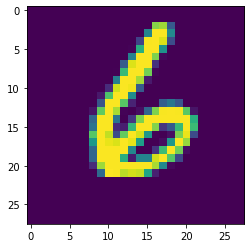

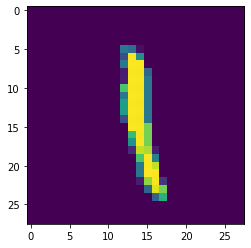

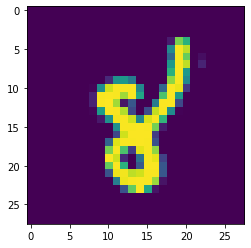

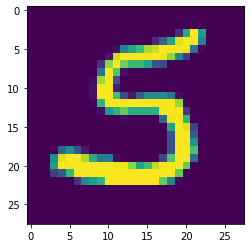

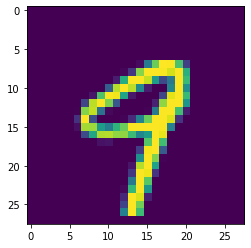

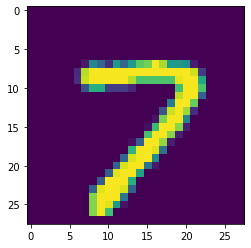

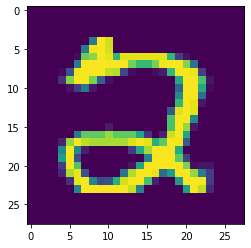

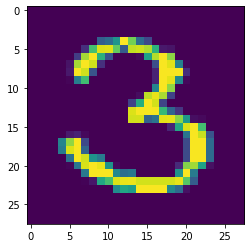

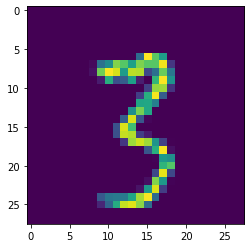

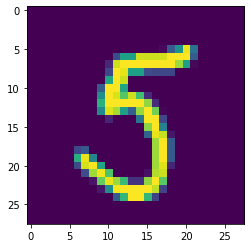

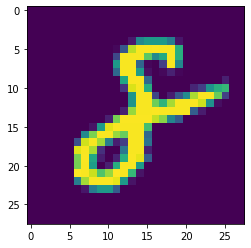

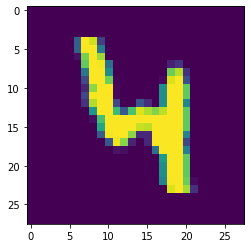

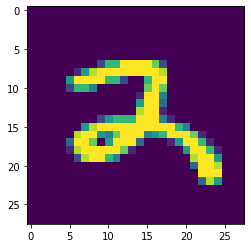

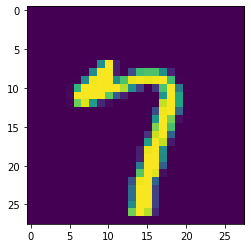

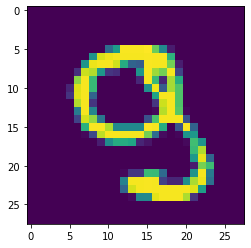

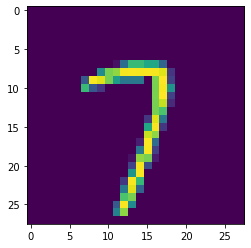


Test set: Average loss: 0.0861, Accuracy: 9748/10000 (97%)



In [31]:
test(model, device, test_loader, test_loss)

In [11]:
# неплохой показатель, делаем цифар 10
import torchvision
import torchvision.transforms as transforms

# я так понял сетку мы не меняем, просто ресайзим изображение в трансофрме?
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))],
#     transforms.Resize(28,28)
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [12]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
new_net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = new_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

In [13]:
total =0
correct =0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = new_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


cuda
tensor([[2]], device='cuda:0')
tensor([[-2.9798, -2.1556, -1.2750, -1.8086, -3.0001, -3.5338, -2.9303, -1.8060,
         -2.7498, -3.5251]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


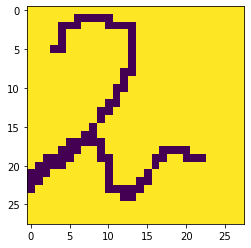

tensor([[2]], device='cuda:0')
tensor([[-2.5819, -2.3419, -1.4271, -1.5941, -2.8735, -3.1842, -2.7182, -2.0553,
         -2.7872, -3.4559]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


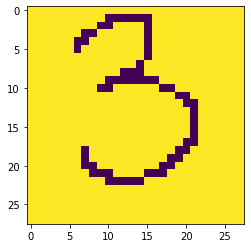

tensor([[2]], device='cuda:0')
tensor([[-2.8668, -2.5837, -0.9335, -1.9247, -3.4214, -3.9802, -3.1918, -1.9336,
         -2.7771, -3.5323]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


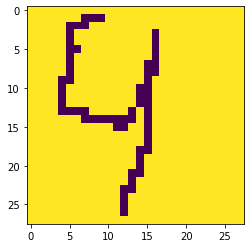

tensor([[2]], device='cuda:0')
tensor([[-2.9454, -2.2390, -1.2741, -1.5707, -3.7840, -3.7627, -3.2228, -1.6302,
         -3.1032, -3.6237]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


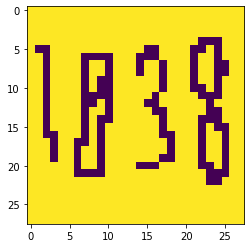

tensor([[0]], device='cuda:0')
tensor([[-0.8417, -4.8161, -2.6716, -3.5732, -2.5117, -3.6127, -2.9550, -2.3794,
         -2.8080, -1.8932]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


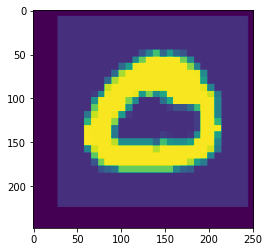

tensor([[2]], device='cuda:0')
tensor([[-3.4360, -2.5944, -0.9525, -1.5436, -3.7022, -4.1761, -3.4456, -2.1279,
         -2.6050, -3.5462]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


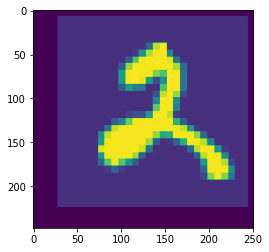

tensor([[6]], device='cuda:0')
tensor([[-2.9846, -2.8678, -2.1956, -2.0877, -1.9821, -2.6305, -1.6482, -2.6828,
         -2.2688, -2.4852]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


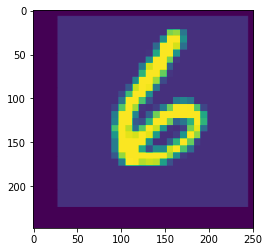

In [32]:
PATH_TO_MY = "../cifri/"

import glob
from skimage import io
# transform = transforms.Compose([
# transforms.PILToTensor()
# ])
print(device)
from PIL import Image

data_transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
# PATH_TO_te_kotorie_na_teste 

for cifra in glob.glob(PATH_TO_MY +"*.png"):
    img = Image.open(cifra).convert('L')
    img.save(cifra)
for cifra in [*glob.glob(PATH_TO_MY +"*.png"), *glob.glob("data/" + "*.png")]:
#     img = io.imread(cifra)
    img = Image.open(cifra).convert('L')
    image = data_transform(img).unsqueeze(0).cuda()
#     img_tensor = torch.from_numpy(img).float().to(device)
#     print(img_tensor)
#     img_tensor=img_tensor.view(-1,28*28)
    model.eval()
#     img_tensor = transform(image)
    
#     img_tensor.float().to(device)
#     print(img_tensor)

    output = model(image)
    pred = output.argmax(dim=1, keepdim=True)
    print(pred)
    print(output)
    plt.imshow(img)
    plt.show()
    

        Ну что мы можем наблюдать, на моих циферках работает плохо, даже бы сказал что не работает, я скопировал из оутпута на тесте  и они норм на них работают, пороб

cuda
tensor([[3]], device='cuda:0')
tensor([[-3.8297, -2.6438, -2.4000, -0.3610, -5.1745, -3.2855, -3.6630, -3.9238,
         -3.6092, -5.5369]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


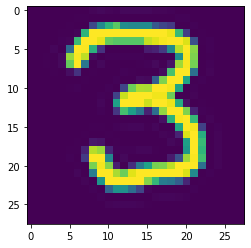

tensor([[4]], device='cuda:0')
tensor([[-2.6856, -2.3452, -2.5919, -2.2759, -2.0110, -2.3473, -2.5019, -2.1162,
         -2.1932, -2.1633]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


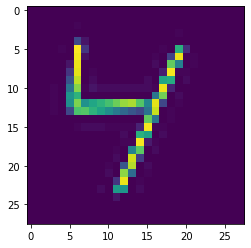

tensor([[3]], device='cuda:0')
tensor([[-3.1460, -1.9938, -2.2255, -1.4707, -3.5122, -1.8339, -2.4548, -2.3631,
         -2.5407, -3.3647]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


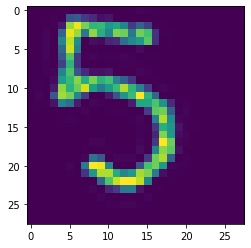

tensor([[1]], device='cuda:0')
tensor([[-3.6960, -0.9053, -2.2190, -2.4373, -2.8292, -3.7639, -3.0228, -1.8351,
         -2.7691, -3.8442]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


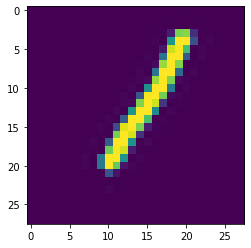

tensor([[0]], device='cuda:0')
tensor([[-0.8260, -4.8664, -2.6928, -3.6142, -2.5284, -3.6605, -3.0018, -2.3380,
         -2.8684, -1.8881]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


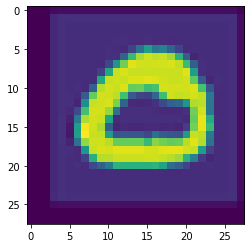

tensor([[2]], device='cuda:0')
tensor([[-3.5165, -2.5973, -0.9308, -1.5450, -3.7480, -4.2737, -3.5258, -2.0873,
         -2.6472, -3.6317]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


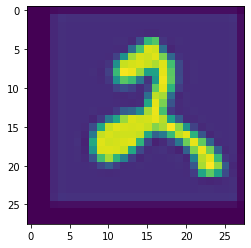

tensor([[6]], device='cuda:0')
tensor([[-3.0101, -2.9070, -2.2104, -2.0868, -1.9852, -2.5933, -1.6205, -2.7114,
         -2.2841, -2.4758]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


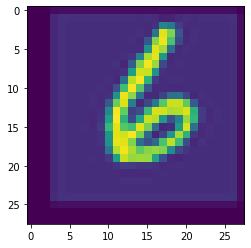

In [37]:
PATH_TO_MY = "../cifri_big/"

import glob
from skimage import io
# transform = transforms.Compose([
# transforms.PILToTensor()
# ])
print(device)
from PIL import Image

data_transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
# PATH_TO_te_kotorie_na_teste 

# for cifra in glob.glob(PATH_TO_MY +"*.png"):
#     img = Image.open(cifra).convert('L')
#     img.save(cifra)
for cifra in [*glob.glob(PATH_TO_MY +"*.png"), *glob.glob("data/" + "*.png")]:
#     img = io.imread(cifra)
    img = Image.open(cifra).convert('L')
    img = img.resize((28,28), resample=Image.ANTIALIAS)
    image = data_transform(img).unsqueeze(0).cuda()
#     img_tensor = torch.from_numpy(img).float().to(device)
#     print(img_tensor)
#     img_tensor=img_tensor.view(-1,28*28)
    model.eval()
#     img_tensor = transform(image)
    
#     img_tensor.float().to(device)
#     print(img_tensor)

    output = model(image)
    pred = output.argmax(dim=1, keepdim=True)
    print(pred)
    print(output)
    plt.imshow(img)
    plt.show()

АГА! когда фон на черный поменял, заработало